In [ ]:
import nibabel as nib # library for loading nii files
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load mask for region of interest (BA3b) + Stim > Null
mask_load = nib.load('../content/rPSC_3b_TR50_right_CUT_Stim_vs_Null.nii').get_fdata()

In [ ]:
# loading contrast stim_press > null for all subjects

sub_inds = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

con_1_files = ['sub_' + ind + '_con_0001.nii' for ind in sub_inds]

stim_press = []
for file in con_1_files:
  con_1_load = nib.load(file).get_fdata()
  con_1_mask = con_1_load[mask_load != 0]
  stim_press.append(con_1_mask)

con_2_files = ['sub_' + ind + '_con_0002.nii' for ind in sub_inds]

# loading contrast stim_flutt > null for all subjects

stim_flutt = []
for file in con_2_files:
  con_2_load = nib.load(file).get_fdata()
  con_2_mask = con_2_load[mask_load != 0]
  stim_flutt.append(con_2_mask)

# loading contrast stim_vibro > null for all subjects

# con_3_files = ['sub_' + ind + '_con_0003.nii' for ind in sub_inds]

# stim_vibro = []
# for file in con_3_files:
#   con_3_load = nib.load(file).get_fdata()
#   con_3_mask = con_3_load[mask_load != 0]
#   stim_vibro.append(con_3_mask)

In [ ]:
data = stim_press + stim_flutt
labels = [0] * 10 + [1] * 10 # 0 - press, 1 - flutt

In [ ]:
from sklearn import svm

model = svm.SVC(kernel="linear")
model.fit(data, labels)

print(model.predict(data)) # predictions for svm from all data

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1]


In [ ]:
# confusion matrix
conf_s_s = 0
conf_f_f = 0
conf_s_f = 0
conf_f_s = 0

# cross-validation
for i in range(10):
  stim_press_1 = []
  stim_flutt_1 = []
  for j in range(10):
    if j != i: # leave-one-out
      stim_press_1.append(list(stim_press[j]))
      stim_flutt_1.append(list(stim_flutt[j]))

  data_1 = stim_press_1 + stim_flutt_1
  labels_1 = [0] * 9 + [1] * 9

  model.fit(data_1, labels_1)

  # predict on left out data
  pred_0, pred_1 = model.predict([stim_press[i], stim_flutt[i]])

  if pred_0 == 0:
    conf_s_s += 1 # correct stim
  else:
    conf_s_f += 1 # incorrect stim

  if pred_1 == 1:
    conf_f_f += 1 # correct flutt
  else:
    conf_f_s += 1 # incorrect flutt

# convert to percent minus 50/50 chance
conf = [[(conf_s_s / 10 - 0.5) * 100, (conf_s_f / 10 - 0.5) * 100], [(conf_f_s / 10 - 0.5) * 100, (conf_f_f / 10 - 0.5) * 100]]

print(conf)

[[30.000000000000004, -30.0], [19.999999999999996, -20.0]]


([<matplotlib.axis.XTick at 0x7daf53e063b0>,
 [Text(0.0, 0, 'stim_press'), Text(1.0, 0, 'stim_flutt')])

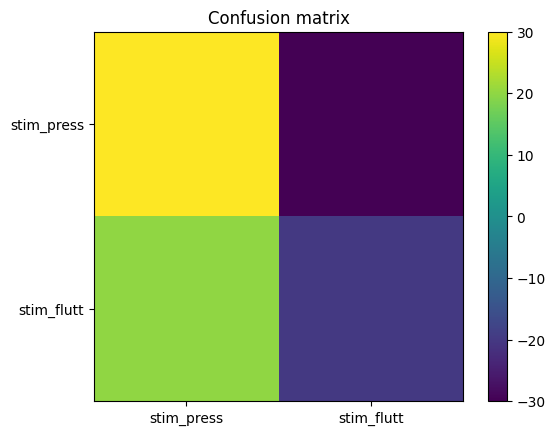

In [ ]:
# show confusion matrix
plt.figure()
im = plt.imshow(conf)
plt.title('Confusion matrix')
plt.colorbar()
plt.yticks([0.0, 1.0], ['stim_press', 'stim_flutt'])
plt.xticks([0.0, 1.0], ['stim_press', 'stim_flutt'])